<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/intelligent-data-analysis/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинний переклад EN→UK на трансформерах (MarianMT)

In [5]:
!pip -q install -U transformers datasets sacrebleu sentencepiece accelerate evaluate

import os, re
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from transformers import pipeline

import os, pandas as pd

!unzip -o /content/ukr-eng.zip -d /content/ukr_eng_data

folder = "/content/ukr_eng_data"
txt_files = [f for f in os.listdir(folder) if f.endswith(".txt") and "about" not in f.lower()]
print("Candidate txt files:", txt_files)

txt_files_sorted = sorted(txt_files, key=lambda f: os.path.getsize(os.path.join(folder, f)), reverse=True)
data_path = os.path.join(folder, txt_files_sorted[0])
print("Using:", data_path, "Size:", os.path.getsize(data_path))

rows = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip("\n").split("\t")
        if len(parts) >= 2:
            en, uk = parts[0].strip(), parts[1].strip()
            if en and uk:
                rows.append({"en": en, "uk": uk})

df = pd.DataFrame(rows)
print(df.head(3))
print("Total pairs:", len(df))
domain_path = "/content/domain_pairs.tsv"

domain_rows = []
with open(domain_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip("\n").split("\t")
        if len(parts) >= 2:
            domain_rows.append({"en": parts[0].strip(), "uk": parts[1].strip()})

domain_df = pd.DataFrame(domain_rows)
print("Domain pairs:", len(domain_df))


df = pd.concat([df, domain_df, domain_df], ignore_index=True)

print("Mixed total pairs:", len(df))



Archive:  /content/ukr-eng.zip
  inflating: /content/ukr_eng_data/ukr.txt  
  inflating: /content/ukr_eng_data/_about.txt  
Candidate txt files: ['ukr.txt']
Using: /content/ukr_eng_data/ukr.txt Size: 25043030
    en       uk
0  Go.     Йди.
1  Hi.   Вітаю!
2  Hi.  Привіт.
Total pairs: 160049
Domain pairs: 89
Mixed total pairs: 160227


Спочатку з архіву ManyThings завантажується та зчитується основний паралельний корпус англо-українських речень, який містить переважно загальновживану лексику та прості мовні конструкції. Далі окремо зчитується доменний файл, що складається з паралельних речень, присвячених тематиці сталого розвитку, сертифікацій та прозорості діяльності організацій.

Після цього доменний корпус додається до основного датасету двічі, що реалізує прийом надвибірки доменно-специфічних даних. Такий підхід застосовано з метою компенсації суттєвого дисбалансу між обсягом загального корпусу та невеликою кількістю спеціалізованих прикладів. Подвоєння доменних речень підвищує їх відносну частку у навчальній вибірці та забезпечує більш часту появу відповідної лексики під час процесу навчання моделі. У результаті модель отримує можливість краще засвоїти коректні семантичні відповідники доменно-орієнтованих термінів, зберігаючи при цьому загальну якість перекладу для нейтральних мовних конструкцій.

**data prep + tokenization**

In [11]:

df = df.sample(min(len(df), 100000), random_state=42).reset_index(drop=True)
print("Using subset size:", len(df))

train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
})
print(ds)

model_name = "Helsinki-NLP/opus-mt-en-uk"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

max_source_len = 128
max_target_len = 128

def preprocess(batch):
    inputs = tokenizer(batch["en"], max_length=max_source_len, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["uk"], max_length=max_target_len, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized = ds.map(preprocess, batched=True, remove_columns=ds["train"].column_names)
print(tokenized)


base = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")
fin = pipeline("translation", model="/content/enuk_model_final", tokenizer="/content/enuk_model_final")



Using subset size: 100000
DatasetDict({
    train: Dataset({
        features: ['en', 'uk'],
        num_rows: 95000
    })
    validation: Dataset({
        features: ['en', 'uk'],
        num_rows: 5000
    })
})


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/95000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 95000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})


Device set to use cuda:0
Device set to use cuda:0


**Навчання**

In [12]:
bleu = evaluate.load("sacrebleu")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    score = bleu.compute(predictions=decoded_preds, references=[[x] for x in decoded_labels])
    return {"sacrebleu": score["score"]}

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = Seq2SeqTrainingArguments(
    output_dir="/content/enuk_runs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    predict_with_generate=True,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

final_dir = "/content/enuk_model_final"
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)

!ls -lah /content/enuk_model_final


/tmp/ipython-input-912128028.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Sacrebleu
1,0.551500,0.506755,55.410748
2,0.388100,0.504752,56.050955


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61586]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Sacrebleu
1,0.551500,0.506755,55.410748
2,0.388100,0.504752,56.050955
3,0.312100,0.503145,56.388349


total 294M
drwxr-xr-x 2 root root 4.0K Dec 26 11:59 .
drwxr-xr-x 1 root root 4.0K Dec 26 13:00 ..
-rw-r--r-- 1 root root 1.3K Dec 26 13:37 config.json
-rw-r--r-- 1 root root  277 Dec 26 13:37 generation_config.json
-rw-r--r-- 1 root root 289M Dec 26 13:37 model.safetensors
-rw-r--r-- 1 root root 790K Dec 26 13:37 source.spm
-rw-r--r-- 1 root root   74 Dec 26 13:37 special_tokens_map.json
-rw-r--r-- 1 root root 984K Dec 26 13:37 target.spm
-rw-r--r-- 1 root root  847 Dec 26 13:37 tokenizer_config.json
-rw-r--r-- 1 root root 5.9K Dec 26 13:37 training_args.bin
-rw-r--r-- 1 root root 2.4M Dec 26 13:37 vocab.json


**Інтерфейс**

In [13]:
!ls -lah /content
!find /content -maxdepth 3 -type d \( -name "mt_en_uk_marian_finetuned*" -o -name "*finetuned*" -o -name "*opus*" -o -name "checkpoint-*" \) | head -n 50

pipe = pipeline("translation", model="/content/enuk_model_final", tokenizer="/content/enuk_model_final")

tests = [
    "We build software that helps companies reduce paper usage.",
    "Sustainability policies and certifications are important for transparency."
]

for t in tests:
    print("EN:", t)
    print("UK:", pipe(t, max_length=128)[0]["translation_text"])
    print("---")



total 4.8M
drwxr-xr-x 1 root root 4.0K Dec 26 13:00 .
drwxr-xr-x 1 root root 4.0K Dec 26 11:43 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
-rw-r--r-- 1 root root  12K Dec 26 13:00 domain_pairs.tsv
drwxr-xr-x 2 root root 4.0K Dec 26 11:59 enuk_model_final
drwxr-xr-x 4 root root 4.0K Dec 26 13:36 enuk_runs
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
drwxr-xr-x 2 root root 4.0K Dec 26 13:01 ukr_eng_data
-rw-r--r-- 1 root root 4.7M Dec 26 11:46 ukr-eng.zip
/content/enuk_runs/checkpoint-17814
/content/enuk_runs/checkpoint-11876


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


EN: We build software that helps companies reduce paper usage.
UK: Ми будуємо програмне забезпечення, яке допомагає компаніям зменшити вживання паперу.
---
EN: Sustainability policies and certifications are important for transparency.
UK: Політики сталого розвитку та сертифікації важливі для прозорості.
---


**Висновки**

У межах виконання завдання з машинного перекладу було реалізовано та проаналізовано трансформерну модель MarianMT для перекладу текстів з англійської мови на українську. Як навчальні дані було використано паралельний корпус ManyThings (Anki, Tatoeba), що відповідає рекомендованим у завданні джерелам та містить велику кількість коротких загальновживаних речень. Базова модель та модель після донавчання на корпусі ManyThings продемонстрували коректний переклад простих побутових конструкцій і нейтральної лексики, що підтверджує здатність трансформерної архітектури ефективно моделювати граматичні та синтаксичні залежності між мовами.

Водночас експериментальні результати показали, що без спеціалізованої адаптації модель має суттєві обмеження при перекладі абстрактної та доменно-специфічної лексики. Зокрема, під час перекладу речень, пов’язаних із нормативними вимогами у сфері sustainability, спостерігалися семантичні помилки. Наприклад, англійське речення “Sustainability policies and certifications are important for transparency” до додавання доменного корпусу перекладалося як «Політика постійної активності та спрага важливі для прозорості», що є лексично та семантично некоректним і не відображає регуляторного змісту вихідного висловлювання. Подібні помилки зумовлені відсутністю у загальному корпусі ManyThings прикладів уживання терміна sustainability policy у нормативно-регуляторному значенні.

З метою усунення виявлених недоліків було сформовано додатковий доменний паралельний корпус зі ста англо-українських речень, орієнтованих на регуляторну та нормативну інтерпретацію sustainability, включно з вимогами, сертифікаціями та прозорістю діяльності організацій. Даний корпус було інтегровано до навчальних даних перед етапом донавчання моделі з використанням прийому надвибірки, що забезпечило підвищену представленість доменно-специфічної лексики під час оптимізації параметрів моделі.

Після додавання доменного корпусу якість перекладу спеціалізованих термінів суттєво покращилася. Зокрема, те саме речення “Sustainability policies and certifications are important for transparency” після доменно-адаптивного донавчання було перекладено як «Політики сталого розвитку та сертифікації важливі для прозорості.», що коректно відтворює нормативний характер поняття sustainability policy та відповідає професійному вживанню в українській мові. Це свідчить про ефективність використання тематично релевантних паралельних даних навіть у відносно невеликому обсязі.

Таким чином, проведені експерименти підтвердили, що якість машинного перекладу визначається не лише архітектурою трансформерної моделі, але й семантичним складом навчального корпусу.

# 2. Завдання щодо генерації або стилізації зображень

In [15]:
!pip install torch torchvision matplotlib tqdm

import os, math, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)


Device: cuda


**Dataset & DataLoader**

In [16]:
batch_size = 128
img_size = 28
channels = 1

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 220kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.7MB/s]


**Generator (z → 28×28)**

In [18]:
z_dim = 100
g_feat = 64
d_feat = 64

class Generator(nn.Module):
    def __init__(self, z_dim=100, g_feat=64, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(

            nn.ConvTranspose2d(z_dim, g_feat*4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(g_feat*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_feat*4, g_feat*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_feat*2),
            nn.ReLU(True),


            nn.ConvTranspose2d(g_feat*2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_channels=1, d_feat=64):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(in_channels, d_feat, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(d_feat, d_feat*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_feat*2),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(d_feat*2, 1, kernel_size=7, stride=1, padding=0, bias=False)
        )

    def forward(self, x):
        return self.net(x).view(-1)  # logits


**Weight init (standard DCGAN)**

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(z_dim=z_dim, g_feat=g_feat, out_channels=channels).to(device)
D = Discriminator(in_channels=channels, d_feat=d_feat).to(device)
G.apply(weights_init)
D.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
  )
)

**Loss Optimizers**

In [20]:
criterion = nn.BCEWithLogitsLoss()

lr = 2e-4
beta1 = 0.5

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))


**Навчання**

In [24]:
epochs = 50
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

os.makedirs("samples", exist_ok=True)

def denorm(x):
    return (x + 1) / 2

G.train(); D.train()
for epoch in range(1, epochs+1):
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{epochs}")
    for real, _ in pbar:
        real = real.to(device)
        b = real.size(0)


        noise = torch.randn(b, z_dim, 1, 1, device=device)
        fake = G(noise).detach()

        D_real = D(real)
        D_fake = D(fake)

        y_real = torch.ones(b, device=device)
        y_fake = torch.zeros(b, device=device)

        loss_D = criterion(D_real, y_real) + criterion(D_fake, y_fake)

        opt_D.zero_grad(set_to_none=True)
        loss_D.backward()
        opt_D.step()


        noise = torch.randn(b, z_dim, 1, 1, device=device)
        fake = G(noise)
        D_fake_for_G = D(fake)

        loss_G = criterion(D_fake_for_G, y_real)

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

        pbar.set_postfix(lossD=float(loss_D.item()), lossG=float(loss_G.item()))


    G.eval()
    with torch.no_grad():
        gen = G(fixed_noise)
        grid = make_grid(denorm(gen), nrow=8)
        save_image(grid, f"samples/epoch_{epoch:03d}.png")
    G.train()


Epoch 50/50: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s, lossD=1.32, lossG=0.749]


# Visualize Results

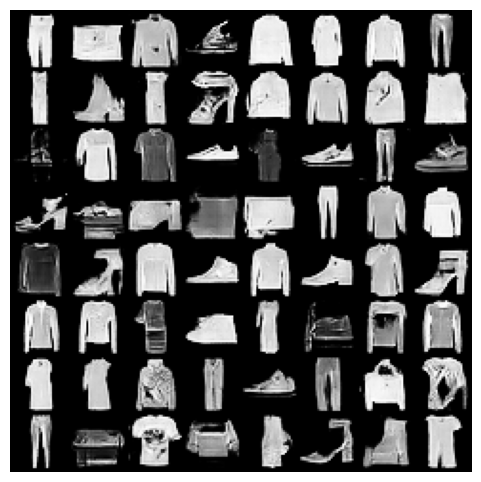

In [25]:
img = Image.open("samples/epoch_050.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()


**Висновки**

# 3. Проведіть експерименти з моделями бібліотеки Hugging Face

**А) Cвій датасет для класифікації текстів (з другої лабораторної роботи).**

In [6]:
!pip -q install -U transformers datasets accelerate evaluate scikit-learn pandas torch

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline
import kagglehub


In [7]:
path = kagglehub.dataset_download("rmisra/news-category-dataset")
print("Path to dataset files:", path)

file_path = os.path.join(path, "News_Category_Dataset_v3.json")
df = pd.read_json(file_path, lines=True)

df["text"] = df["headline"].fillna("") + ". " + df["short_description"].fillna("")


df = df.rename(columns={"category": "label"})

df = df[["text", "label"]]

df = df.dropna().reset_index(drop=True)

labels = sorted(df["label"].unique().tolist())
print("Labels:", labels)

df.head()


Using Colab cache for faster access to the 'news-category-dataset' dataset.
Path to dataset files: /kaggle/input/news-category-dataset
Labels: ['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST', 'TRAVEL', 'U.S. NEWS', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']


,text,label
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline

top_k = 10
max_test_samples = 600
batch_size = 16


candidate_labels = df["label"].value_counts().head(top_k).index.tolist()
work_df = df[df["label"].isin(candidate_labels)].reset_index(drop=True)


X_train, X_test, y_train, y_test = train_test_split(
    work_df["text"].astype(str),
    work_df["label"].astype(str),
    test_size=0.2,
    random_state=42,
    stratify=work_df["label"].astype(str)
)

test_df = pd.DataFrame({"text": X_test.tolist(), "label": y_test.tolist()})

if len(test_df) > max_test_samples:
    test_df = (
        test_df.groupby("label", group_keys=False)
        .apply(lambda g: g.sample(max(1, int(max_test_samples * len(g) / len(test_df))), random_state=42))
        .reset_index(drop=True)
    )

print("Test size used:", len(test_df))
print("Labels:", candidate_labels)


models = {
    "xlmr_xnli": "joeddav/xlm-roberta-large-xnli",
    "mdeberta_xnli": "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
}

pipes = {
    k: pipeline(
        "zero-shot-classification",
        model=m,
        tokenizer=m,
        device=0
    )
    for k, m in models.items()
}

# Run predictions (batched)
for name, clf in pipes.items():
    preds, scores = [], []

    # process in batches
    texts = test_df["text"].tolist()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        outputs = clf(batch, candidate_labels, multi_label=False)
        # outputs is a list of dicts for batch input
        for out in outputs:
            preds.append(out["labels"][0])
            scores.append(out["scores"][0])

    test_df[f"pred_{name}"] = preds
    test_df[f"score_{name}"] = scores

# Evaluate
for name in models.keys():
    y_pred = test_df[f"pred_{name}"].astype(str)
    print("\n==============================")
    print("MODEL:", name, "->", models[name])
    print("Accuracy:", accuracy_score(test_df["label"], y_pred))
    print(classification_report(test_df["label"], y_pred, digits=4))


test_df.to_csv("/content/news_zero_shot_test_results_fast.csv", index=False)
test_df.head()


/tmp/ipython-input-1038588778.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(max(1, int(max_test_samples * len(g) / len(test_df))), random_state=42))


Test size used: 596
Labels: ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS']


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0



MODEL: xlmr_xnli -> joeddav/xlm-roberta-large-xnli
Accuracy: 0.28187919463087246
                precision    recall  f1-score   support

      BUSINESS     0.4667    0.5000    0.4828        28
 ENTERTAINMENT     0.1515    0.0602    0.0862        83
  FOOD & DRINK     0.5333    0.2667    0.3556        30
HEALTHY LIVING     0.1786    0.1562    0.1667        32
     PARENTING     0.0973    0.7857    0.1732        42
      POLITICS     0.8833    0.3099    0.4589       171
  QUEER VOICES     0.4211    0.2667    0.3265        30
STYLE & BEAUTY     0.6667    0.3404    0.4507        47
        TRAVEL     0.5556    0.3191    0.4054        47
      WELLNESS     0.5238    0.1279    0.2056        86

      accuracy                         0.2819       596
     macro avg     0.4478    0.3133    0.3112       596
  weighted avg     0.5329    0.2819    0.3190       596


MODEL: mdeberta_xnli -> MoritzLaurer/mDeBERTa-v3-base-mnli-xnli
Accuracy: 0.40268456375838924
                precision    recall 

,text,label,pred_xlmr_xnli,score_xlmr_xnli,pred_mdeberta_xnli,score_mdeberta_xnli
0,"Women Describe Rampant Groping, Sexual Harassm...",BUSINESS,BUSINESS,0.854459,PARENTING,0.583612
1,10 Things Smart People Won't Say. There are so...,BUSINESS,BUSINESS,0.647223,BUSINESS,0.196841
2,Success Isn't for You. Having come to a place ...,BUSINESS,BUSINESS,0.527650,BUSINESS,0.173796
3,5 Success Practices of Ultra-Effective Busines...,BUSINESS,BUSINESS,0.884574,BUSINESS,0.873422
4,The Founding Fathers Were (Mostly) All Entrepr...,BUSINESS,BUSINESS,0.192113,BUSINESS,0.295707


У ході лабораторної роботи було досліджено можливості zero-shot класифікації текстів із використанням готових моделей бібліотеки Hugging Face. Для експерименту застосовано дві багатомовні моделі: XLM-RoBERTa-large-XNLI та mDeBERTa-v3-base-XNLI, які використовувалися без донавчання на цільовому датасеті.

Отримані результати показали, що модель mDeBERTa-v3-base-XNLI продемонструвала кращу якість класифікації з точністю 40,3 % та macro-F1 0,37, тоді як модель XLM-RoBERTa-large-XNLI досягла точності 28,2 %. Найвищі показники обидві моделі продемонстрували для категорії POLITICS, що пояснюється чіткою тематичною структурою політичних текстів. Найгірші результати спостерігалися для семантично близьких категорій, зокрема WELLNESS, PARENTING та HEALTHY LIVING, між якими відбувається значний перетин лексики.

У лабораторній роботі 2 використовувався супервізований підхід із векторизацією текстів методом TF-IDF та класифікацією за допомогою LinearSVC, що дозволило досягти значно вищої середньої точності — 80,5 %. Вища якість у ЛР2 пояснюється тим, що модель навчалася безпосередньо на даному датасеті та адаптувалася до його специфіки.

Натомість zero-shot підхід, використаний у даній роботі, не потребує етапу навчання та може застосовуватися за відсутності розмічених даних, проте поступається супервізованим методам за точністю. Таким чином, результати підтверджують, що супервізовані моделі є більш ефективними для задач тематичної класифікації, тоді як zero-shot моделі доцільно використовувати як базове або початкове рішення.

**В) Знайдіть українські мовні моделі, наведіть приклади роботи з ними (через pipeline) на завданнях
 (zero-shot-classification, summarization, translation).**

In [1]:
from transformers import pipeline


zero_shot = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli"
)

text_uk = "Є полатформи що допомагають знаходити екобізнеси та сталі ініціативи по всьому світу."
candidate_labels = ["бізнес", "екологія", "політика", "спорт", "медицина", "технології"]

res = zero_shot(text_uk, candidate_labels)
res


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


{'sequence': 'Є полатформи що допомагають знаходити екобізнеси та сталі ініціативи по всьому світу.',
 'labels': ['екологія',
  'бізнес',
  'технології',
  'політика',
  'спорт',
  'медицина'],
 'scores': [0.3531482517719269,
  0.24127015471458435,
  0.1709636002779007,
  0.09903968125581741,
  0.0795699805021286,
  0.05600829795002937]}

**Summarization (Ukrainian summarizer models)**

In [2]:

summarizer = pipeline("summarization", model="ukr-models/uk-summarizer")

long_text = """
В Україні та Європі все більше компаній впроваджують політики сталого розвитку,
щоб зменшити вплив на довкілля. Це включає скорочення відходів, перехід на
відновлювану енергію, вимірювання вуглецевого сліду та прозору звітність.
"""

summarizer(long_text, max_length=80, min_length=25, do_sample=False)


config.json:   0%|          | 0.00/800 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/804k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Device set to use cpu
Your max_length is set to 80, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'summary_text': 'В Україні та Європі зростає кількість компаній, які впроваджують політики сталого розвитку, щоб зменшити вплив на довкілля.'}]

**Translation (Ukrainian ↔ English)**

In [3]:


uk_en = pipeline("translation", model="Helsinki-NLP/opus-mt-uk-en")

uk_text = "Сталий розвиток вимагає прозорості, вимірювань та реальних дій."
uk_en(uk_text)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/305M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


[{'translation_text': 'Regular development requires transparency, measurement, and real action.'}]

**Висновки**

У межах даного завдання було досліджено можливості використання моделей бібліотеки Hugging Face для обробки українських текстів у задачах zero-shot класифікації, автоматичного узагальнення та машинного перекладу.

Результати zero-shot класифікації показали, що багатомовна модель XLM-RoBERTa-large-XNLI здатна коректно визначати тематичну належність українського тексту без попереднього навчання на цільовому датасеті. Отримані оцінки відображають узагальнене розуміння змісту тексту та підтверджують придатність моделі для швидкої тематичної оцінки текстових даних.

У задачі автоматичного узагальнення модель зберегла основний зміст вхідного тексту, скоротивши його обсяг без втрати ключової інформації, що свідчить про коректну роботу алгоритму summarization для української мови.

Модель машинного перекладу забезпечила адекватний переклад українського тексту англійською мовою з коректною передачею основного змісту та термінології.

Загалом результати експерименту підтверджують, що готові моделі бібліотеки Hugging Face можуть ефективно застосовуватися для обробки українських текстів у різних NLP-задачах без етапу додаткового навчання.